#  PJM Interconnetion Queue Analysis
Bill Louer

<img src = "https://drive.tiny.cloud/1/8cadf6pkwkhsiz9mruuj1hgybj2xd7ww2v1as8ktymfewkug/5a7141fe-d7aa-46a1-8e14-ad46762cbd29" >

## Table of Contents


1.  [Background](#1)<br>
2.  [Objectives](#2) <br>
3.  [Input Data and Create SQL Database](#2A) <br>
4.  [Project List Characterization](#3) <br>
5.  [Project Types, Interconnecting Transmission Systems and Project Locations:](#4) <br>
6.  [Distribution of Unit Interconnection Costs for Projects in the Study Cluster:](#5) <br>
7.  [Limitations and Next Steps](#6) <br>
</div>


## Background: <a id="1"></a>
- PJM implemented a transition from a serial study approach of each project to a cluster study approach for New Service Requests entering the PJM interconnection process.
- During this transition, PJM needed to analyze the first cluster of projects which had applied for interconnection but had not yet completed the serial study process.  
- Subsequently, PJM conducted load flow analyses to determine whether active AE1-AG1 queued projects would be eligible for the Expedited Process or be reprioritized to Transition Cycle 1 (TC1).
- The projects that were analyzed by PJM for Transition Cycle 1 (TC1) are the subject of this analysis.

## Objectives: <a id="2"></a>
- Create a SQL database of PJM Interconnection Projects for future update and analysis
- Determine the distribution of projects in the interconnection queue by:
    - Technology
    - MW Capacity
    - Location
    - Interconnecting Utility
- Determine distribution of price of interconnection for projects in the interconnection queue
- Downloaded the raw data (csv_files) and filed it in the raw_data folder which consisted of the following csv files:
    - Project List
    - Network Upgrade Costs
    - System Reinforcement Costs (The share of system reliability project costs are already included in the Network Upgrade Cost Table) 
    - Data Source:  "https://www.pjm.com/pub/planning/project-queues/Cluster-Reports/TC1/TC1_PH1_Executive_Summary.htm"
-  Questions:
    -  How are the project divided by MW, Utility(region), technology
    -  What is the total cost to interconnect per MW?  How does it vary across the projects?
    -  Is there any correlation between interconnection costs and project size?

In [1]:
# !pip install pywaffle
# #import Waffle from pywaffle using terminal

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from pywaffle import Waffle
import seaborn as sns
import os
%matplotlib inline

In [3]:
#  Load the sql extension from ipython into the notebook.
%load_ext sql

## Import Data and Create SQL Database  <a id="2A"></a>
-  Import data from csv files
-  Create SQL Database
-  Define SQL table schema with column names, primary keys, and datatypes

In [4]:
#  Establish location for database output file and establish connection to create a new database.
BASE_DIR = os.path.dirname(os.path.abspath('PJM_Interconnect.ipynb')).replace('\\notebooks', '')
db_name = 'pjm_interconnect.dB'
db_path = os.path.join(BASE_DIR, 'data\\raw',  db_name)
print(db_path)
# define filepath for plots
plt_filepath = os.path.join(BASE_DIR, 'reports\\figures')
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

C:\Users\Bill\OneDrive\Work\DataScienceProjects\UTL000001_PJM_Interconnect\data\raw\pjm_interconnect.dB


In [5]:
#  Import csv files
files = {"project_list": "pjm_project_list_table1.csv",
             "network_upgrades": "pjm_network_upgrade_table2.csv",
             "system_reinforcements": "pjm_system_reinforements_table3.csv"  }
df_list = []
n=0
for key in files.keys():
    filename = files[key]
    filepath = os.path.join(BASE_DIR, 'data\\raw',  filename)
    df_list.append( pd.read_csv(filepath, skiprows=1))
    new_col = [ x.replace('/', '').replace('(', '').replace(')', '').replace(' ', '_') for x in list(df_list[n].columns)]
    df_list[n].columns = new_col
    n+=1
    # df.to_sql(key, conn, if_exists='replace')

In [6]:
#  Shorten column names
df_list[0].columns = ['Project_ID', 'Project_Name_POI', 'State', 'Status',
       'Transmission_Owner', 'Max_Facility_MW',
       'MW_Energy', 'MW_Capacity', 'Project_Type', 'Resource_Type']
df_list[1].columns = ['Project_ID', 'Trans_Owner_Interc_Facilities',
       'Interconnect_Network_Upgrades',
       'Sys_Rel_Network_Upgrades',
       'Sys_Study_Reinforcements', 'Total_Cost']
df_list[2].columns =  ['TO', 'RTEP_ID_TO_ID', 'Title', 'Time_Estimate',
       'Total_Cost_Est$', 'Projects_with_Cost_Allocation',
       'Contingent_Projects']

In [7]:
# create an index column in the system_reinforcements df
new_column_values = [f"SR-{id}" for id in np.linspace(0, df_list[2].shape[0]-1, len(df_list[2])).astype(int)]
df_list[2].insert(0, "SR_Project_ID", new_column_values )

In [8]:
#  Make sure datatypes are correct.

#  network upgrade table
filter = ['Trans_Owner_Interc_Facilities', 'Interconnect_Network_Upgrades', 'Sys_Rel_Network_Upgrades', 
           'Sys_Study_Reinforcements', 'Total_Cost']
df_list[1][filter] = df_list[1][filter].map(lambda x: x.strip('$').strip(','))
for col in filter:
    df_list[1][col] =  pd.to_numeric(df_list[1][col], errors='coerce').astype(float)

#  system reinforcement table
filter = ['Trans_Owner_Interc_Facilities', 'Interconnect_Network_Upgrades', 'Sys_Rel_Network_Upgrades', 
           'Sys_Study_Reinforcements', 'Total_Cost']
df_list[2]['Total_Cost_Est$'] = df_list[2]['Total_Cost_Est$'].map(lambda x: x.strip('$').strip(','))
df_list[2]['Total_Cost_Est$'] =  pd.to_numeric(df_list[2]['Total_Cost_Est$'], errors='coerce').astype(float)


In [9]:
#  Define a new table in SQL database
#  Define new columns in SQL database with primary key, dtypes
table1_q = "CREATE TABLE IF NOT EXISTS project_list ('Project_ID' VARCHAR(10) PRIMARY KEY NOT NULL, 'Project_Name_POI' TEXT, 'State' VARCHAR(2), 'Status' TEXT,\
       'Transmission_Owner' TEXT, 'Max_Facility_MW' FLOAT, 'MW_Energy' FLOAT, 'MW_Capacity' FLOAT, 'Project_Type' TEXT, 'Resource_Type' TEXT)"
cursor.execute(table1_q)
table2_q = "CREATE TABLE IF NOT EXISTS network_upgrades ('Project_ID' VARCHAR(20) PRIMARY KEY NOT NULL, 'Trans_Owner_Interc_Facilities' FLOAT,\
       'Interconnect_Network_Upgrades' FLOAT , 'Sys_Rel_Network_Upgrades' FLOAT, 'Sys_Study_Reinforcements' FLOAT, 'Total_Cost' FLOAT)"
cursor.execute(table2_q)
table3_q = "CREATE TABLE IF NOT EXISTS system_reinforcements ('SR_Project_ID' VARCHAR(20) PRIMARY KEY NOT NULL, 'TO' TEXT, 'RTEP_ID_TO_ID' TEXT, 'Title' TEXT, 'Time_Estimate' TEXT,\
       'Total_Cost_Est$' FLOAT, 'Projects_with_Cost_Allocation' TEXT, 'Contingent_Projects' TEXT)"
cursor.execute(table3_q)
#  Upload the dataframe tables (without headers) to the SQL database so that they can be queried. 
for d_frame, key in zip(df_list, files.keys()):
    d_frame.to_sql(key, conn, if_exists='append', index=None) 

In [10]:
%sql sqlite:///{db_path}

In [11]:
%sql Select name FROM sqlite_master WHERE type = 'table';

 * sqlite:///C:\Users\Bill\OneDrive\Work\DataScienceProjects\UTL000001_PJM_Interconnect\data\raw\pjm_interconnect.dB
Done.


name
project_list
network_upgrades
system_reinforcements


In [12]:
%sql PRAGMA table_info([project_list]);

 * sqlite:///C:\Users\Bill\OneDrive\Work\DataScienceProjects\UTL000001_PJM_Interconnect\data\raw\pjm_interconnect.dB
Done.


cid,name,type,notnull,dflt_value,pk
0,Project_ID,VARCHAR(10),1,None,1
1,Project_Name_POI,TEXT,0,None,0
2,State,VARCHAR(2),0,None,0
3,Status,TEXT,0,None,0
4,Transmission_Owner,TEXT,0,None,0
5,Max_Facility_MW,FLOAT,0,None,0
6,MW_Energy,FLOAT,0,None,0
7,MW_Capacity,FLOAT,0,None,0
8,Project_Type,TEXT,0,None,0
9,Resource_Type,TEXT,0,None,0


In [13]:
#  Query all project techical data and total project cost.  Note:  system reinforcement costs are already included in the network upgrade cost table.
query = """SELECT P.Project_ID, P.Project_Name_POI, P.State, P.Transmission_Owner, P.Max_Facility_MW, P.MW_Energy, P.MW_Capacity, P.Project_type, 
P.Resource_type, N.Trans_Owner_Interc_Facilities, N.Interconnect_Network_Upgrades, N.Sys_Rel_Network_Upgrades, N.Sys_Study_Reinforcements, N.Total_Cost 
FROM project_list P INNER JOIN network_upgrades N ON P.Project_ID = N.Project_ID"""

In [14]:
df_pjm = pd.read_sql(query, conn)
df_pjm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Project_ID                     306 non-null    object 
 1   Project_Name_POI               306 non-null    object 
 2   State                          306 non-null    object 
 3   Transmission_Owner             306 non-null    object 
 4   Max_Facility_MW                306 non-null    float64
 5   MW_Energy                      306 non-null    float64
 6   MW_Capacity                    306 non-null    float64
 7   Project_Type                   306 non-null    object 
 8   Resource_Type                  303 non-null    object 
 9   Trans_Owner_Interc_Facilities  306 non-null    float64
 10  Interconnect_Network_Upgrades  306 non-null    float64
 11  Sys_Rel_Network_Upgrades       306 non-null    float64
 12  Sys_Study_Reinforcements       306 non-null    flo

In [15]:
# check NaN values
df_pjm.isna().sum()

Project_ID                       0
Project_Name_POI                 0
State                            0
Transmission_Owner               0
Max_Facility_MW                  0
MW_Energy                        0
MW_Capacity                      0
Project_Type                     0
Resource_Type                    3
Trans_Owner_Interc_Facilities    0
Interconnect_Network_Upgrades    0
Sys_Rel_Network_Upgrades         0
Sys_Study_Reinforcements         0
Total_Cost                       0
dtype: int64

In [16]:
#  Merchant Transmission Projects are not assigned a resource type.  I will assign "Transmission" to this resource type.
df_pjm.loc[df_pjm.Resource_Type.isna()==True, "Resource_Type"] = "Transmission"

####  Extract Interconnect Voltage of Project Name Column and calculate POI_Amperage

In [17]:
#  add a column for interconnection voltage to see if this impacts interconnection cost or cost per kW
voltage_list = [12.5, 13.2, 46, 34.5, 69,  115, 138, 161, 230, 345, 500, 765]

for voltage in voltage_list:
    df_pjm.loc[df_pjm["Project_Name_POI"].str.contains(str(voltage)), "POI_Voltage"] = float(voltage)

# calculate the ampacity of the interconnection 
# (MW * 10**6)/ (sqrt(3)*Voltage * 0.9 (Assumed Power factor)

df_pjm["POI_Amperage"] = (df_pjm.Max_Facility_MW*1000) / (df_pjm.POI_Voltage * 0.9 * 3**0.5)

In [18]:
df_pjm["Unit_Cost$perkW"] = df_pjm.Total_Cost/(df_pjm.Max_Facility_MW*1000)

##  Project List Characterization: <a id="3"></a>
- Number of projects in the interconnection queue by Resource type
- Number of MW in the interconnection queue by Resource type
- Number of MW in the interconnection queue by Transmission Owner
- Number of MW in the interconnection queue by state

In [19]:
df_resource = df_pjm[["State", "Transmission_Owner", "Resource_Type", "Max_Facility_MW", "Trans_Owner_Interc_Facilities",
       "Interconnect_Network_Upgrades", "Sys_Rel_Network_Upgrades", "Sys_Study_Reinforcements", "Total_Cost", "Unit_Cost$perkW"]]

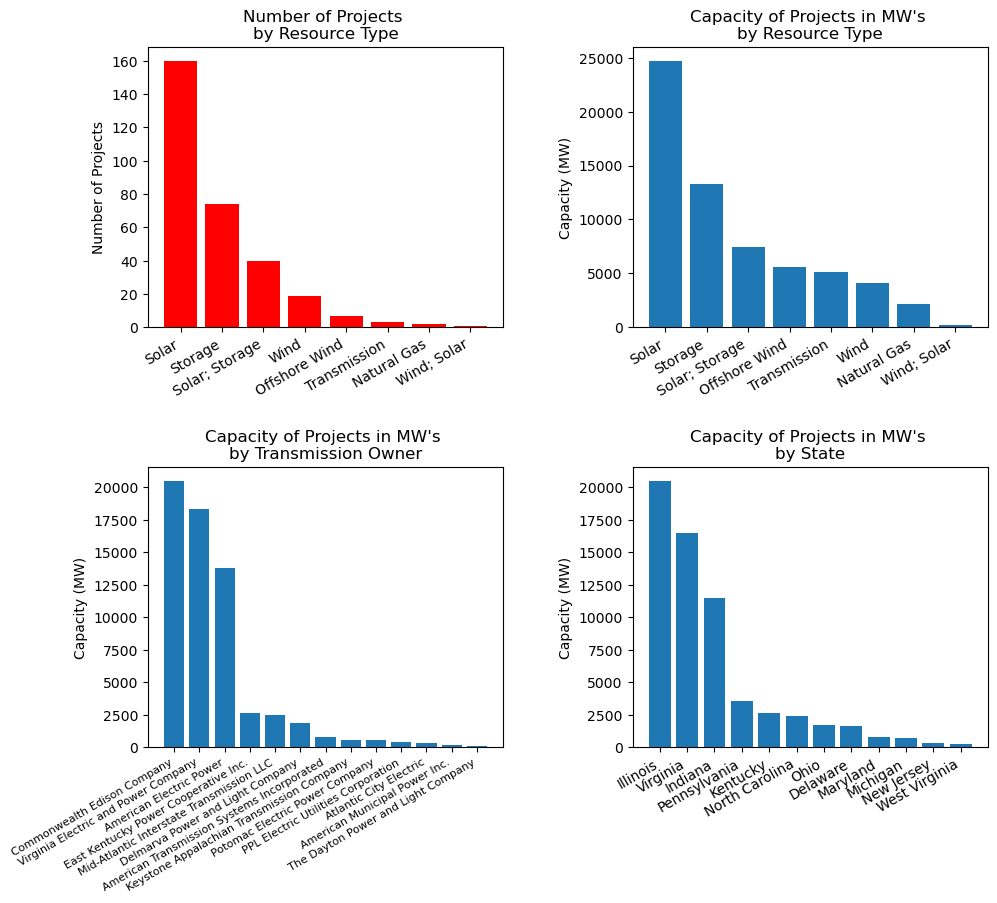

In [57]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1.bar(x = df_resource["Resource_Type"].value_counts().index, height=df_resource["Resource_Type"].value_counts().values, color="red")
ax1.set_title("Number of Projects \nby Resource Type")
ax1.set_ylabel("Number of Projects")
ax1.set_xticks(range(len(df_resource["Resource_Type"].value_counts().index)))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha="right", fontsize=10)

df_MW = df_resource[["Resource_Type", "Max_Facility_MW" ]].groupby(["Resource_Type" ]).sum().sort_values("Max_Facility_MW", ascending=False)
ax2.bar(x = df_MW.index, height=df_MW["Max_Facility_MW"])
ax2.set_title("Capacity of Projects in MW's \nby Resource Type")
ax2.set_ylabel("Capacity (MW)")
ax2.set_xticks(range(len(df_MW.index)))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha="right", fontsize=10)

df_TO = df_resource[["Transmission_Owner", "Max_Facility_MW" ]].groupby(["Transmission_Owner" ]).sum().sort_values("Max_Facility_MW", ascending=False)
ax3.bar(x = df_TO.index, height=df_TO["Max_Facility_MW"])
ax3.set_title("Capacity of Projects in MW's \nby Transmission Owner")
ax3.set_ylabel("Capacity (MW)")
ax3.set_xticks(range(len(df_TO.index)))
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=30, ha="right", fontsize=8)

df_state = df_resource[["State", "Max_Facility_MW" ]].groupby(["State" ]).sum().sort_values("Max_Facility_MW", ascending=False)
ax4.bar(x = df_state.index, height=df_state["Max_Facility_MW"])
ax4.set_title("Capacity of Projects in MW's \nby State")
ax4.set_ylabel("Capacity (MW)")
ax4.set_xticks(range(len(df_state.index)))
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=30, ha="right", fontsize=10)
plt.tight_layout(pad=5 )
# fig.suptitle("PJM Interconnection Cluster (TC1) Project Characterization", fontsize=20)
# Adjust the spacing around subplots
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2, hspace=0.5)

filepath = os.path.join(plt_filepath, "pjm_project_characterization.png" )
plt.savefig(filepath)
plt.show()

##  Project Types, Interconnecting Transmission Systems and Project Locations: <a id="4"></a>
-  Solar, Storage, Solar+Storage and Wind have the highest number of projects in the study cluster. 
-  Solar, Storage, Solar+Storage and Wind have the highest total project capacity (MW's) in the study cluster. 
-  The Transmission Owner's with the most projects under development in the study cluser include ComEd, Virginia E&PC, AEP.
-  The states with the most interconnection projects ongoing include Illinois, Virginia and Indiana

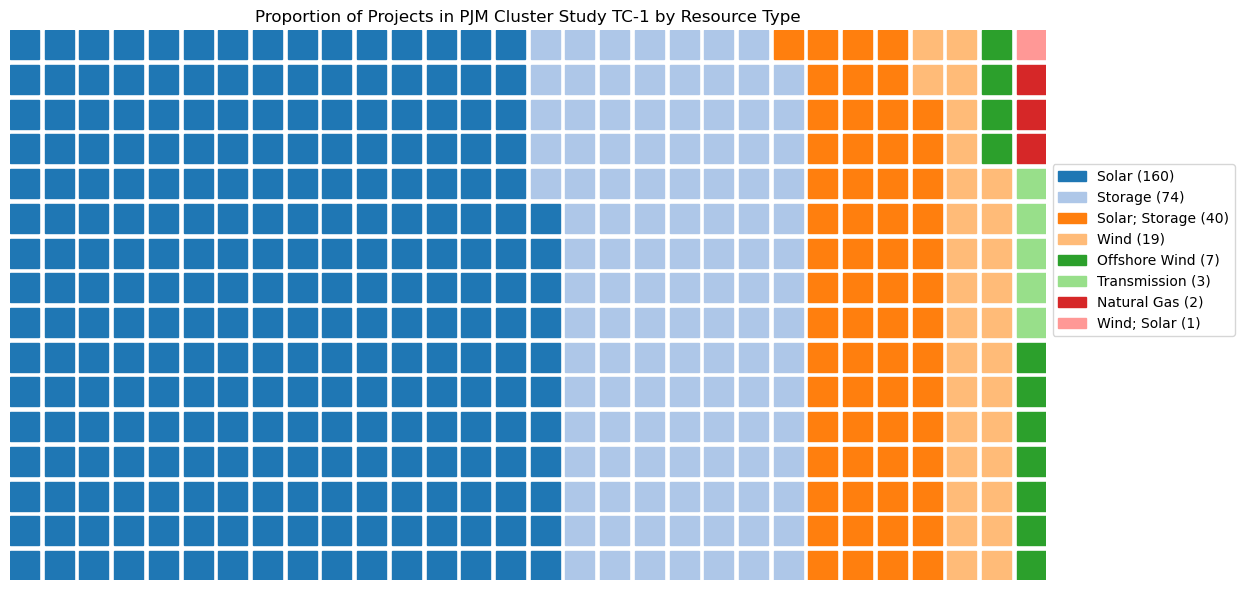

In [68]:

plt.figure(FigureClass = Waffle,
                 rows = 16, columns = 30, #pass the number of rows and columns for the waffle 
                 values = df_resource['Resource_Type'].value_counts(), #pass the data to be used for display
                 cmap_name = 'tab20', #color scheme
                 legend = {'labels': [f"{k} ({v})" for k, v in zip(df_resource['Resource_Type'].value_counts().index,\
                    df_resource['Resource_Type'].value_counts().values)], 'loc': 'center left', 'bbox_to_anchor':(1.0, 0.6),'ncol': 1},
                 figsize=(12.5,6)
                 #notice the use of list comprehension for creating labels 
                 #from index and total of the dataset
                )
plt.title("Proportion of Projects in PJM Cluster Study TC-1 by Resource Type")
#Display the waffle chart
plt.tight_layout()
filepath = os.path.join(plt_filepath, "pjm_projects_by_resource.png" )
plt.savefig(filepath)
plt.show()

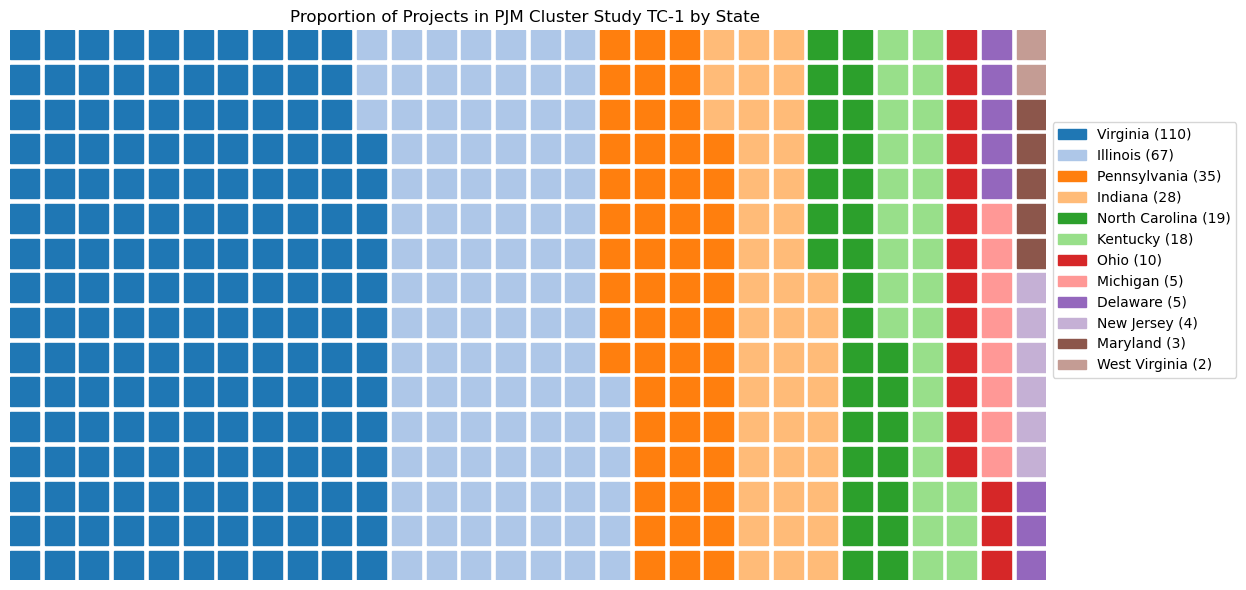

In [69]:
#  Looking at the above a different way with a waffle chart.

plt.figure(FigureClass = Waffle,
                 rows = 16, columns = 30, #pass the number of rows and columns for the waffle 
                 values = df_resource['State'].value_counts(), #pass the data to be used for display
                 cmap_name = 'tab20', #color scheme
                 legend = {'labels': [f"{k} ({v})" for k, v in zip(df_resource['State'].value_counts().index,\
                    df_resource['State'].value_counts().values)], 'loc': 'center left', 'bbox_to_anchor':(1.0, 0.6),'ncol': 1},
                 figsize=(12.5,6)
                 #notice the use of list comprehension for creating labels 
                 #from index and total of the dataset
                )
plt.title("Proportion of Projects in PJM Cluster Study TC-1 by State ")
#Display the waffle chart
plt.tight_layout()
filepath = os.path.join(plt_filepath, "pjm_projects_by_state.png" )
plt.savefig(filepath)
plt.show()

In [23]:
#  Display the MW's in the interconnection queue by state or by Tranmission Owner if i can find a geojson which includes Transmission owner territories.



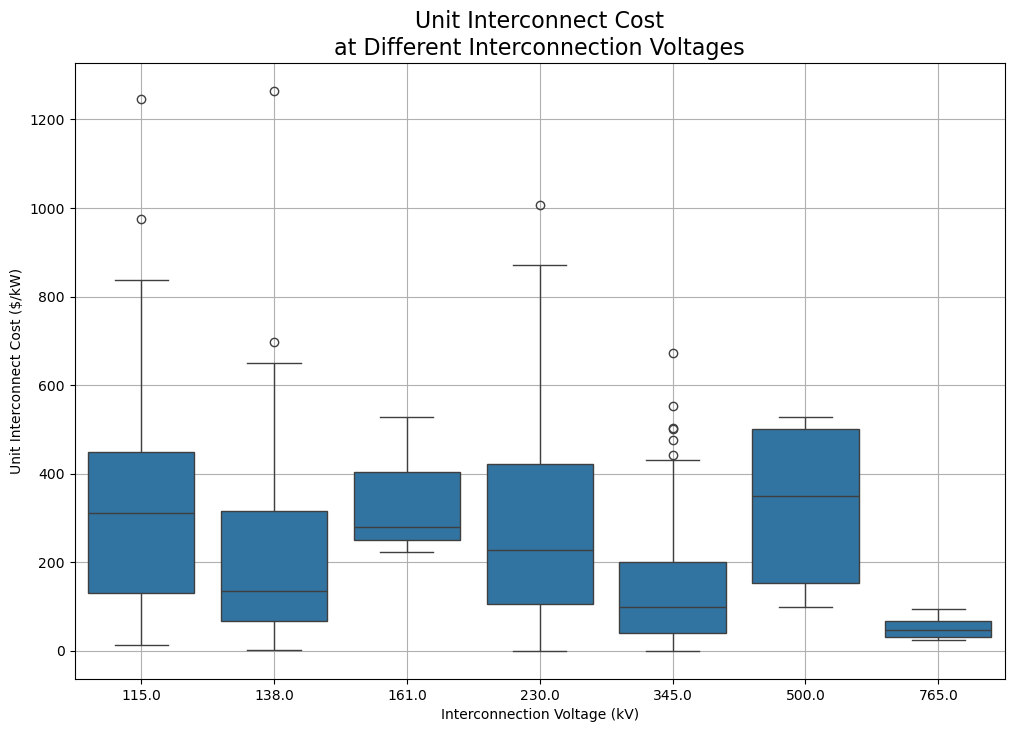

In [77]:
# df_voltage = df_pjm.groupby("POI_Voltage").mean(numeric_only=True)[["Max_Facility_MW", "Total_Cost", "POI_Amperage" ]]
# df_voltage["mean_unit_cost"] = df_voltage.Total_Cost/(df_voltage.Max_Facility_MW*1000)
# df_voltage
_, axs = plt.subplots(1, 1, figsize=(12,8))
# sns.boxplot(x="POI_Voltage", y="Max_Facility_MW", data=df_pjm.loc[df_pjm.POI_Voltage>110,:], ax=axs[0] )
# axs[0].set_title("Project Capacity\nat Different Interconnection Voltages")
# axs[0].set_xlabel("Interconnection Voltage (kV)")
# axs[0].set_ylabel("Rated Facility Output (MW)")
# axs[0].grid()

sns.boxplot(x="POI_Voltage", y="Unit_Cost$perkW", data=df_pjm.loc[df_pjm.POI_Voltage>110,:], ax=axs )
axs.set_title("Unit Interconnect Cost\nat Different Interconnection Voltages", fontsize=16)
axs.set_xlabel("Interconnection Voltage (kV)")
axs.set_ylabel("Unit Interconnect Cost ($/kW)")
axs.grid()
filepath = os.path.join(plt_filepath, "pjm_projects_voltage.png" )
plt.savefig(filepath)
plt.show()

C:\Users\Bill\AppData\Local\Temp\ipykernel_21484\394169821.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs1.set_xticklabels(axs1.get_xticklabels(), rotation=30, ha="right", fontsize=8)
C:\Users\Bill\AppData\Local\Temp\ipykernel_21484\394169821.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs2.set_xticklabels(axs2.get_xticklabels(), rotation=30, ha="right", fontsize=8)
C:\Users\Bill\AppData\Local\Temp\ipykernel_21484\394169821.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs3.set_xticklabels(axs3.get_xticklabels(), rotation=30, ha="right", fontsize=6)


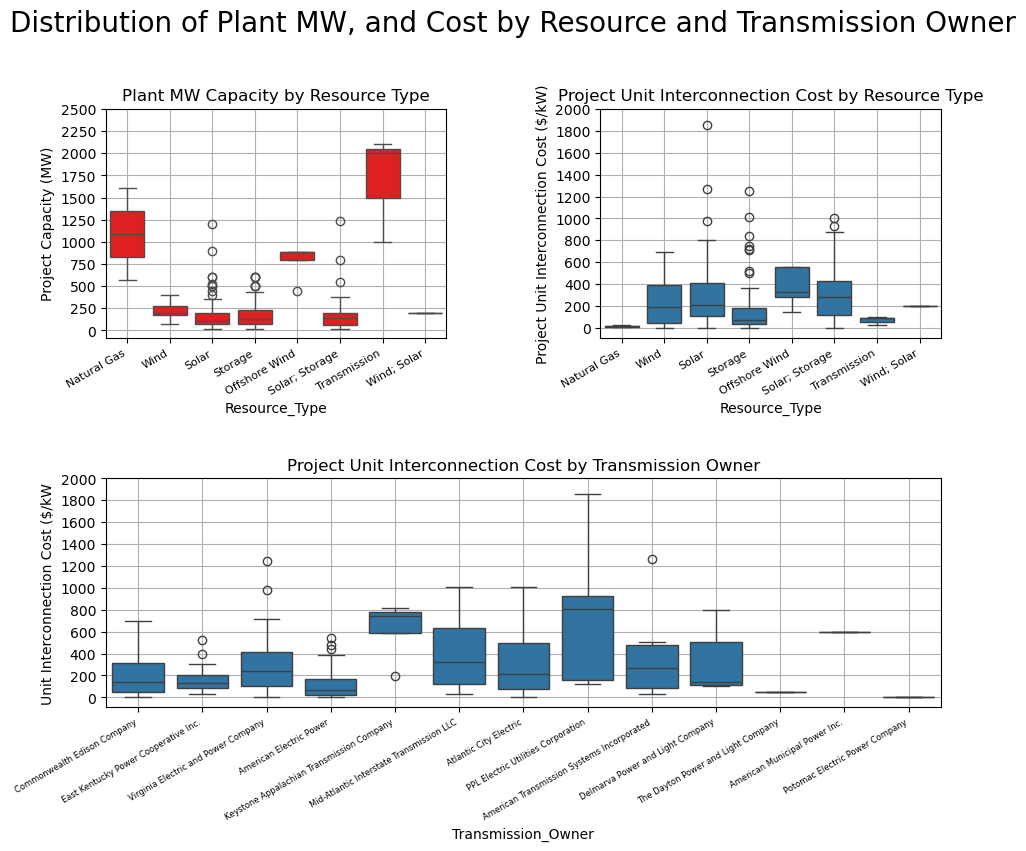

In [75]:
fig = plt.figure(figsize=(11,8.5))
axs1 = fig.add_subplot(2,2, 1)
axs2 = fig.add_subplot(2,2, 2)
axs3 = fig.add_subplot(2,2, (3,4))
plt.tight_layout(pad=8)


sns.boxplot(x="Resource_Type", y="Max_Facility_MW", data=df_resource, ax=axs1, color='red' )
axs1.set_title("Plant MW Capacity by Resource Type")
axs1.set_xticklabels(axs1.get_xticklabels(), rotation=30, ha="right", fontsize=8)
axs1.set_ylabel("Project Capacity (MW)")
axs1.set_yticks(np.linspace(0, 2500, 11))
axs1.grid()

sns.boxplot(x="Resource_Type", y="Unit_Cost$perkW", data=df_resource, ax=axs2 )
axs2.set_title("Project Unit Interconnection Cost by Resource Type")
axs2.set_xticklabels(axs2.get_xticklabels(), rotation=30, ha="right", fontsize=8)
axs2.set_yticks(np.linspace(0, 2000, 11))
axs2.set_ylabel("Project Unit Interconnection Cost ($/kW)")
axs2.grid()

sns.boxplot(x="Transmission_Owner", y="Unit_Cost$perkW", data=df_resource, ax=axs3 )
axs3.set_title("Project Unit Interconnection Cost by Transmission Owner")
axs3.set_xticklabels(axs3.get_xticklabels(), rotation=30, ha="right", fontsize=6)
axs3.set_yticks(np.linspace(0, 2000, 11))
axs3.set_ylabel("Unit Interconnection Cost ($/kW")
axs3.grid()
fig.suptitle("Distribution of Plant MW, and Cost by Resource and Transmission Owner", fontsize=20)
filepath = os.path.join(plt_filepath, "MW_UnitCost_Utility_Boxplots.png" )
plt.savefig(filepath)

plt.show()


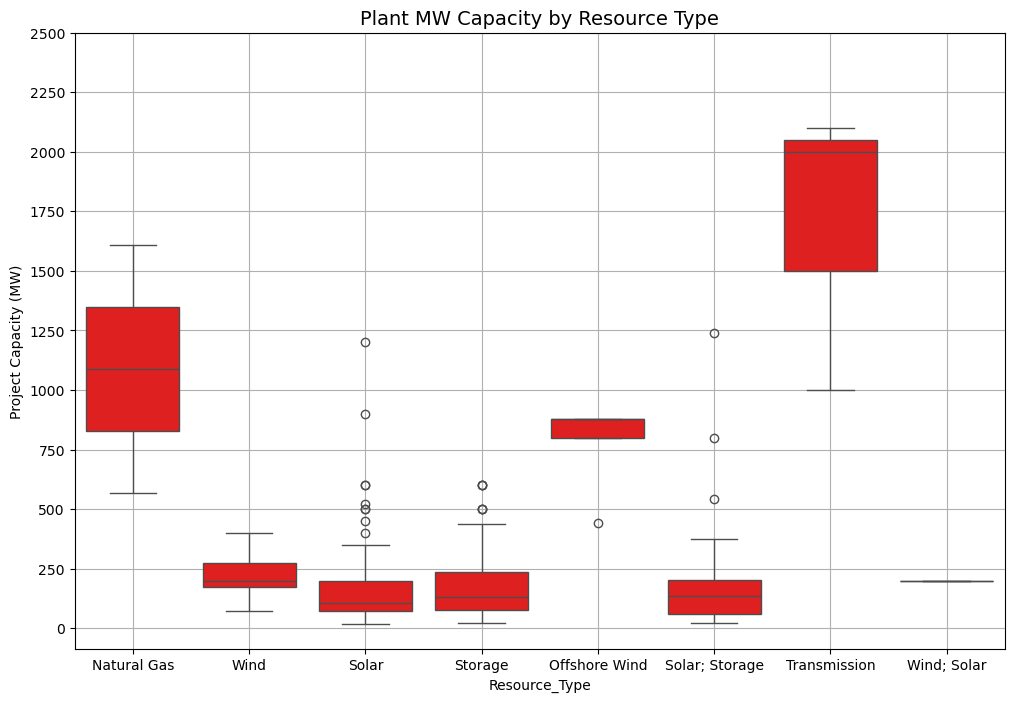

In [89]:

_, axs =  plt.subplots(figsize=(12,8))
sns.boxplot(x="Resource_Type", y="Max_Facility_MW", data=df_resource, ax=axs, color='red' )
axs.set_title("Plant MW Capacity by Resource Type", fontsize=14)
# axs.set_xticklabels(axs.get_xticklabels(), rotation=30, ha="right", fontsize=8)
axs.set_ylabel("Project Capacity (MW)")
axs.set_yticks(np.linspace(0, 2500, 11))
axs.grid()
filepath = os.path.join(plt_filepath, 'plant_MW_resource.png' )
plt.savefig(filepath)
plt.show()


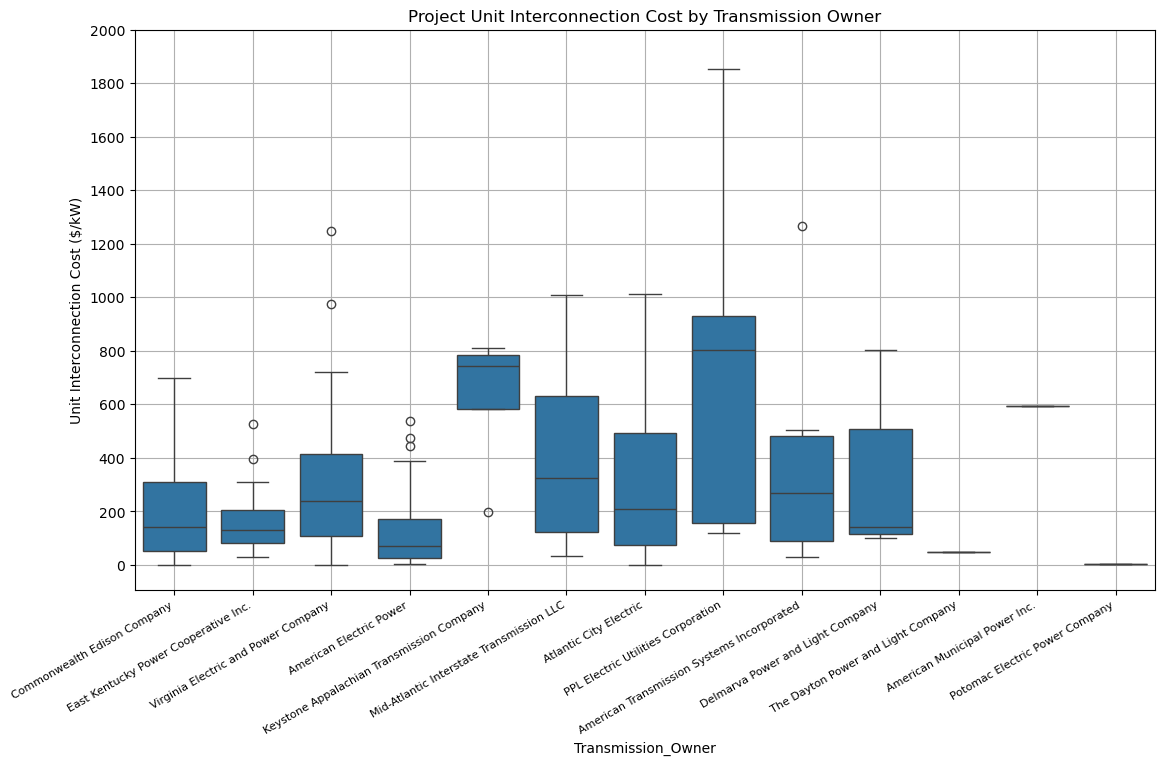

In [102]:
_, axs =  plt.subplots(figsize=(12,8))
sns.boxplot(x="Transmission_Owner", y="Unit_Cost$perkW", data=df_resource, ax=axs )
axs.set_title("Project Unit Interconnection Cost by Transmission Owner")
plt.setp(axs.get_xticklabels(), rotation=30, ha="right", fontsize=8)
axs.set_yticks(np.linspace(0, 2000, 11))
axs.set_ylabel("Unit Interconnection Cost ($/kW)")
axs.grid()
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.2)
filepath = os.path.join(plt_filepath, 'plant_MW_trans_owner.png' )
plt.savefig(filepath)
plt.show()

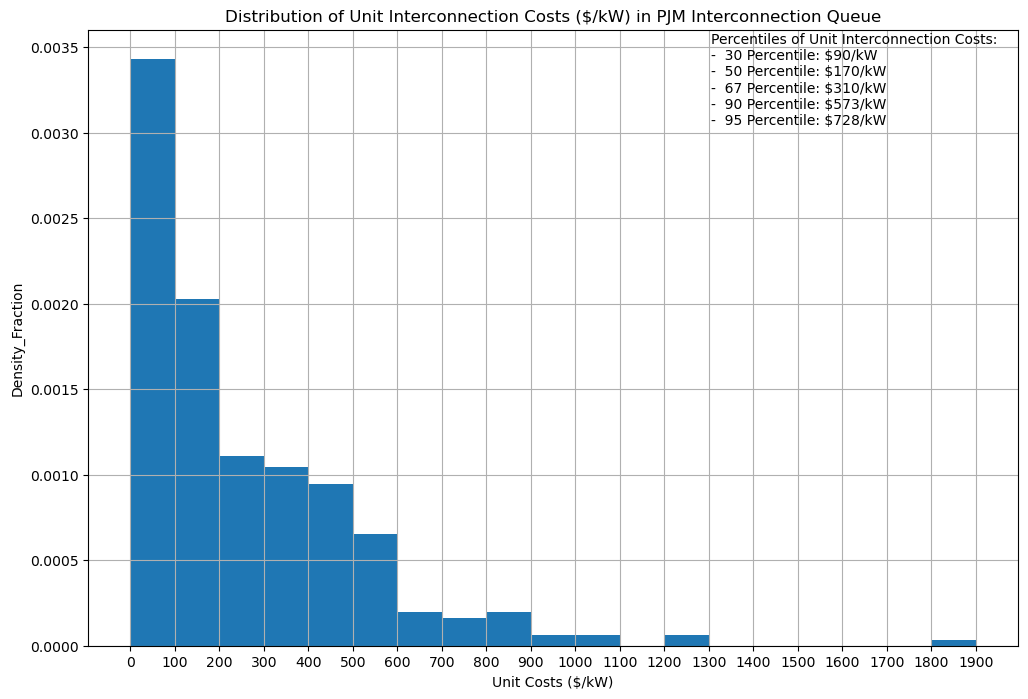

In [29]:
bin_edges = np.linspace(0, 1900, 20)
df_resource["Unit_Cost$perkW"].hist(bins=bin_edges, figsize=(12,8), density=True)
plt.title("Distribution of Unit Interconnection Costs ($/kW) in PJM Interconnection Queue")
plt.xlabel("Unit Costs ($/kW)")
plt.xticks(bin_edges)
plt.ylabel("Density_Fraction")
pct_text = f"Percentiles of Unit Interconnection Costs:\n"\
f"-  30 Percentile: ${stats.scoreatpercentile(df_resource['Unit_Cost$perkW'], [0,30])[1]:.00f}/kW\n" \
f"-  50 Percentile: ${stats.scoreatpercentile(df_resource['Unit_Cost$perkW'], [0,50])[1]:.00f}/kW\n" \
f"-  67 Percentile: ${stats.scoreatpercentile(df_resource['Unit_Cost$perkW'], [0,67])[1]:.00f}/kW\n"\
f"-  90 Percentile: ${stats.scoreatpercentile(df_resource['Unit_Cost$perkW'], [0,90])[1]:.00f}/kW\n"\
f"-  95 Percentile: ${stats.scoreatpercentile(df_resource['Unit_Cost$perkW'], [0,95])[1]:.00f}/kW\n"
plt.annotate(pct_text, xy = (0.67, 0.82)  , xycoords='axes fraction' )
filepath = os.path.join(plt_filepath, "Interconnect_Cost_Freq_Dist.png" )
plt.savefig(filepath)
plt.show()

In [27]:
df_pjm.corr(numeric_only=True)

,Max_Facility_MW,MW_Energy,MW_Capacity,Trans_Owner_Interc_Facilities,Interconnect_Network_Upgrades,Sys_Rel_Network_Upgrades,Sys_Study_Reinforcements,Total_Cost,POI_Voltage,POI_Amperage,Unit_Cost$perkW
Max_Facility_MW,1.000000,0.758976,0.678980,0.234121,0.289189,0.398010,NaN,0.420404,0.494466,0.823229,-0.150703
MW_Energy,0.758976,1.000000,0.870074,0.286714,0.412913,0.606327,NaN,0.627733,0.382153,0.676578,0.030421
MW_Capacity,0.678980,0.870074,1.000000,0.188937,0.149227,0.395624,NaN,0.360012,0.334306,0.551675,-0.029459
Trans_Owner_Interc_Facilities,0.234121,0.286714,0.188937,1.000000,0.336647,0.115506,NaN,0.243653,0.030620,0.265678,0.051745
Interconnect_Network_Upgrades,0.289189,0.412913,0.149227,0.336647,1.000000,0.431063,NaN,0.740358,0.093309,0.359177,0.180505
Sys_Rel_Network_Upgrades,0.398010,0.606327,0.395624,0.115506,0.431063,1.000000,NaN,0.925488,0.177871,0.456080,0.575599
Sys_Study_Reinforcements,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total_Cost,0.420404,0.627733,0.360012,0.243653,0.740358,0.925488,NaN,1.000000,0.171229,0.492397,0.504526
POI_Voltage,0.494466,0.382153,0.334306,0.030620,0.093309,0.177871,NaN,0.171229,1.000000,0.026005,-0.159841
POI_Amperage,0.823229,0.676578,0.551675,0.265678,0.359177,0.456080,NaN,0.492397,0.026005,1.000000,-0.074157


####  Correlation between Project MW size and Unit Cost per kW
-  There is a correlation between total interconnection cost and project MW or POI_Amperage (which is partially related to MW).
-  However, the negative correlation between unit interconnection cost and project MW is not as strong as would have been expected.  (only -0.15)

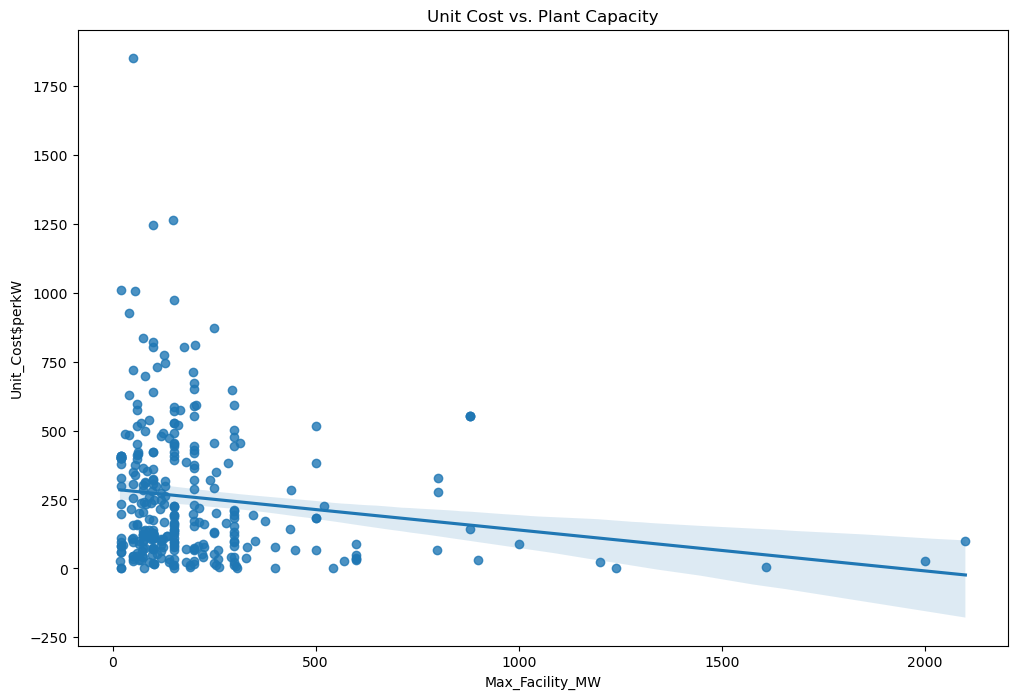

In [82]:
plt.figure(figsize=(12,8))
sns.regplot(x="Max_Facility_MW", y = "Unit_Cost$perkW", data=df_pjm)
plt.title("Unit Cost vs. Plant Capacity")
filepath = os.path.join(plt_filepath, "MW_UnitCost_MW_Capacity.png" )
plt.savefig(filepath)

plt.show()
plt.show()

In [109]:
df_resource_sort = df_resource.sort_values('Unit_Cost$perkW', ascending= True)[0:100]

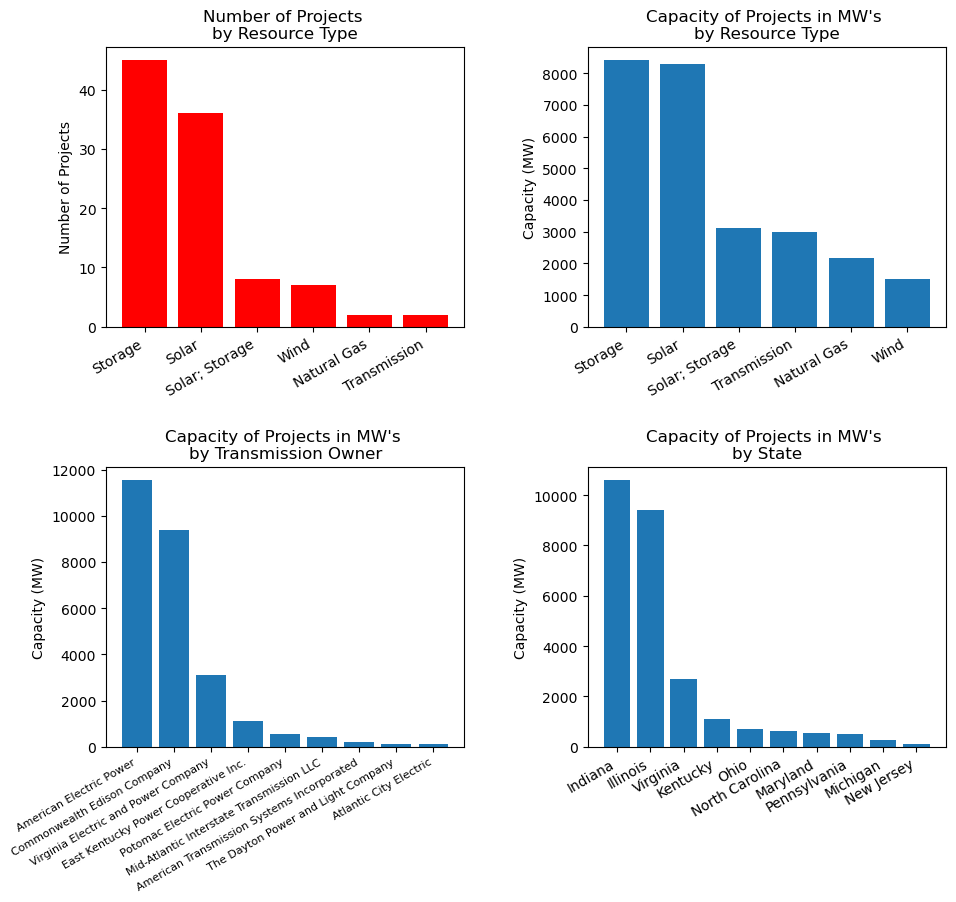

In [110]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1.bar(x = df_resource_sort["Resource_Type"].value_counts().index, height=df_resource_sort["Resource_Type"].value_counts().values, color="red")
ax1.set_title("Number of Projects \nby Resource Type")
ax1.set_ylabel("Number of Projects")
ax1.set_xticks(range(len(df_resource_sort["Resource_Type"].value_counts().index)))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha="right", fontsize=10)

df_MW = df_resource_sort[["Resource_Type", "Max_Facility_MW" ]].groupby(["Resource_Type" ]).sum().sort_values("Max_Facility_MW", ascending=False)
ax2.bar(x = df_MW.index, height=df_MW["Max_Facility_MW"])
ax2.set_title("Capacity of Projects in MW's \nby Resource Type")
ax2.set_ylabel("Capacity (MW)")
ax2.set_xticks(range(len(df_MW.index)))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha="right", fontsize=10)

df_TO = df_resource_sort[["Transmission_Owner", "Max_Facility_MW" ]].groupby(["Transmission_Owner" ]).sum().sort_values("Max_Facility_MW", ascending=False)
ax3.bar(x = df_TO.index, height=df_TO["Max_Facility_MW"])
ax3.set_title("Capacity of Projects in MW's \nby Transmission Owner")
ax3.set_ylabel("Capacity (MW)")
ax3.set_xticks(range(len(df_TO.index)))
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=30, ha="right", fontsize=8)

df_state = df_resource_sort[["State", "Max_Facility_MW" ]].groupby(["State" ]).sum().sort_values("Max_Facility_MW", ascending=False)
ax4.bar(x = df_state.index, height=df_state["Max_Facility_MW"])
ax4.set_title("Capacity of Projects in MW's \nby State")
ax4.set_ylabel("Capacity (MW)")
ax4.set_xticks(range(len(df_state.index)))
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=30, ha="right", fontsize=10)
plt.tight_layout(pad=5 )
# fig.suptitle("PJM Interconnection Cluster (TC1) Project Characterization", fontsize=20)
# Adjust the spacing around subplots
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2, hspace=0.5)

filepath = os.path.join(plt_filepath, "pjm_project_characterization_bottom_35pct.png" )
plt.savefig(filepath)
plt.show()

In [112]:
df_resource_sort.tail(20)

,State,Transmission_Owner,Resource_Type,Max_Facility_MW,Trans_Owner_Interc_Facilities,Interconnect_Network_Upgrades,Sys_Rel_Network_Upgrades,Sys_Study_Reinforcements,Total_Cost,Unit_Cost$perkW
107,Illinois,Commonwealth Edison Company,Solar,400.0,175343.0,17396777.0,13760030.0,0.0,31332150.0,78.330375
129,Kentucky,East Kentucky Power Cooperative Inc.,Solar,225.0,1480000.0,11010000.0,5165072.0,0.0,17655072.0,78.466987
244,Ohio,American Electric Power,Solar,300.0,1365000.0,12407621.0,10412047.0,0.0,24184668.0,80.615560
115,Pennsylvania,Mid-Atlantic Interstate Transmission LLC,Solar,20.0,238297.0,1389983.0,0.0,0.0,1628280.0,81.414000
196,Indiana,American Electric Power,Solar,210.0,1920000.0,11040000.0,4184038.0,0.0,17144038.0,81.638276
238,Virginia,Virginia Electric and Power Company,Solar,20.0,0.0,0.0,1643367.0,0.0,1643367.0,82.168350
128,Illinois,Commonwealth Edison Company,Storage,120.0,550000.0,9500000.0,0.0,0.0,10050000.0,83.750000
86,North Carolina,Virginia Electric and Power Company,Solar,150.0,0.0,0.0,12882229.0,0.0,12882229.0,85.881527
117,Virginia,Virginia Electric and Power Company,Solar,25.0,0.0,0.0,2164851.0,0.0,2164851.0,86.594040
53,Virginia,Virginia Electric and Power Company,Storage,223.5,0.0,0.0,19753615.0,0.0,19753615.0,88.383065


## Distribution of Unit Interconnection Costs for Projects in the Study Cluster: <a id="5"></a>
-  There are roughly 50 % of projects with an interconnection cost under \$170/kW (includes share of system reinforcement costs.)
-  There are roughly 90 % of projects with an interconnection cost under \$573/kW (includes share of system reinforcement costs.)
-  It would be reasonable to assume that projects with a lower cost to interconnect will have a higher probability of going forward.
-  This info. would be useful in assesssing the relative risk of different projects moving forward.
-  Notes:
    -  These are study costs, not actual so it would be useful to see how close PJM has been in estimating interconnection costs.
    -  Nevertheless, these costs are PJM's expectation of interconnection costs and a developer uses these cost estimates to make decisions about their project.
    -  Is there a dataset with actual project interconnection costs to compare this with.
- Further study:
    - For projects that go-forward and actual interconnection agreement cost data is available, what is the cost to interconnect in $/kW and could this provide a better indication of a project interconnection cost threshold for a project to proceed?
    - Can a predictive tool be developed to predict the probability of a project going forward as a function of its interconnection cost?


## Limitations and Next Steps: <a id="6"></a>
-  Limitations:
    -  The costs presented in the data are study costs, not actual contractual costs and therefore are likely to change.
    -  It would be useful to see how accurately PJM has been in estimating interconnection costs by comparing early study costs to contractual interconnection agreement costs.
    -  Nevertheless, these costs are PJM's expectation of interconnection costs and a developer uses these costs as signals to make decisions about their project.
    -  Is there a dataset with actual project interconnection costs to compare this with?
- Further study:
    - For projects that go-forward and actual interconnection agreement cost data is available, what is the cost to interconnect in $/kW and could this provide a better indication of a project interconnection cost threshold for a project to proceed?
    - Can a predictive tool be developed to predict the probability of a project going forward as a function of its interconnction cost?
